In [100]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from pyia import GaiaData
from scipy.interpolate import interp1d

coord.galactocentric_frame_defaults.set('v4.0');

In [170]:
t = at.Table.read('../cache/probs.fits')
d = at.Table.read('../data/150pc_MG12-result.fits.gz')
joined = at.join(d, t, keys='source_id', join_type='left')

g = GaiaData(joined[joined['prob'] > 0.5])
allg = GaiaData(joined)

---

# CMDs

In [171]:
mg = g.phot_g_mean_mag - g.distmod
bprp = g.phot_bp_mean_mag - g.phot_rp_mean_mag

In [172]:
iso = at.Table.read('/mnt/home/apricewhelan/data/isochrones/PARSEC/FeH_0.4_iso.fits')
iso = iso[np.isclose(iso['log(age/yr)'], 8.2)]
iso = iso[iso['stage'] < 2]

In [173]:
iso_interp = interp1d(iso['G'], iso['G_BP']-iso['G_RP'])

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


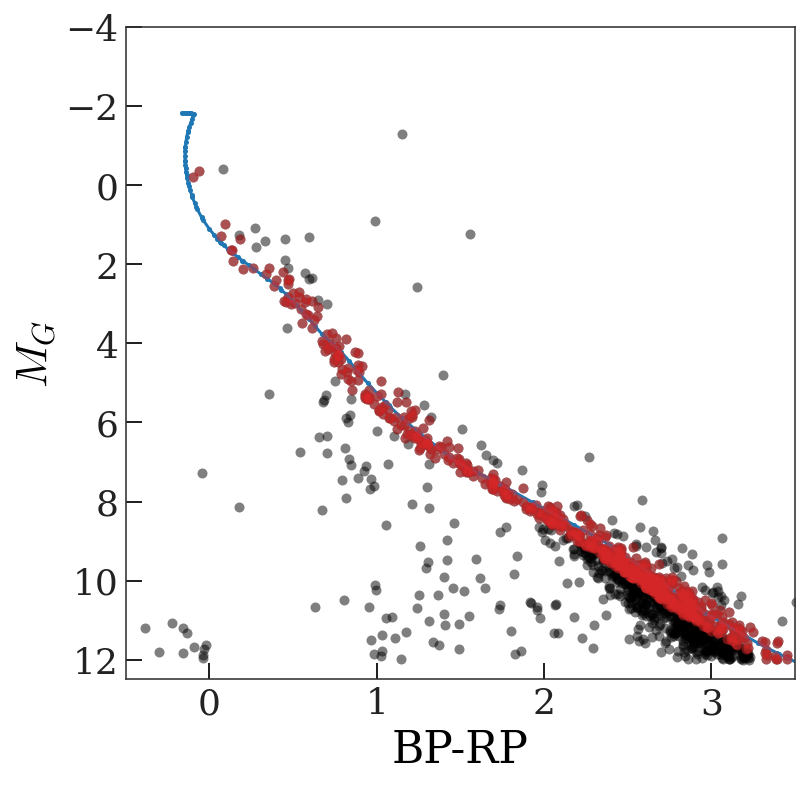

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(bprp, mg, marker='o', ls='none', alpha=0.5, mew=0)

ax.plot(iso['G_BP']-iso['G_RP'], iso['G'])

pred_bprp = iso_interp(mg.value)
cmd_mask = (np.abs(bprp.value - pred_bprp) < 0.15) #& (mg < 9*u.mag)
ax.plot(bprp[cmd_mask], mg[cmd_mask], 
        marker='o', ls='none', alpha=0.5, mew=0, color='tab:red')

ax.set_xlim(-0.5, 3.5)
ax.set_ylim(12.5, -4)

ax.set_xlabel('BP-RP')
ax.set_ylabel('$M_G$')

fig.set_facecolor('w')

In [175]:
c = g.get_skycoord()
galcen = c.transform_to(coord.Galactocentric)

allc = allg.get_skycoord()
allgalcen = allc.transform_to(coord.Galactocentric)

In [176]:
dx = galcen.data.without_differentials() + coord.CartesianRepresentation(galcen.galcen_distance * [1, 0, 0])

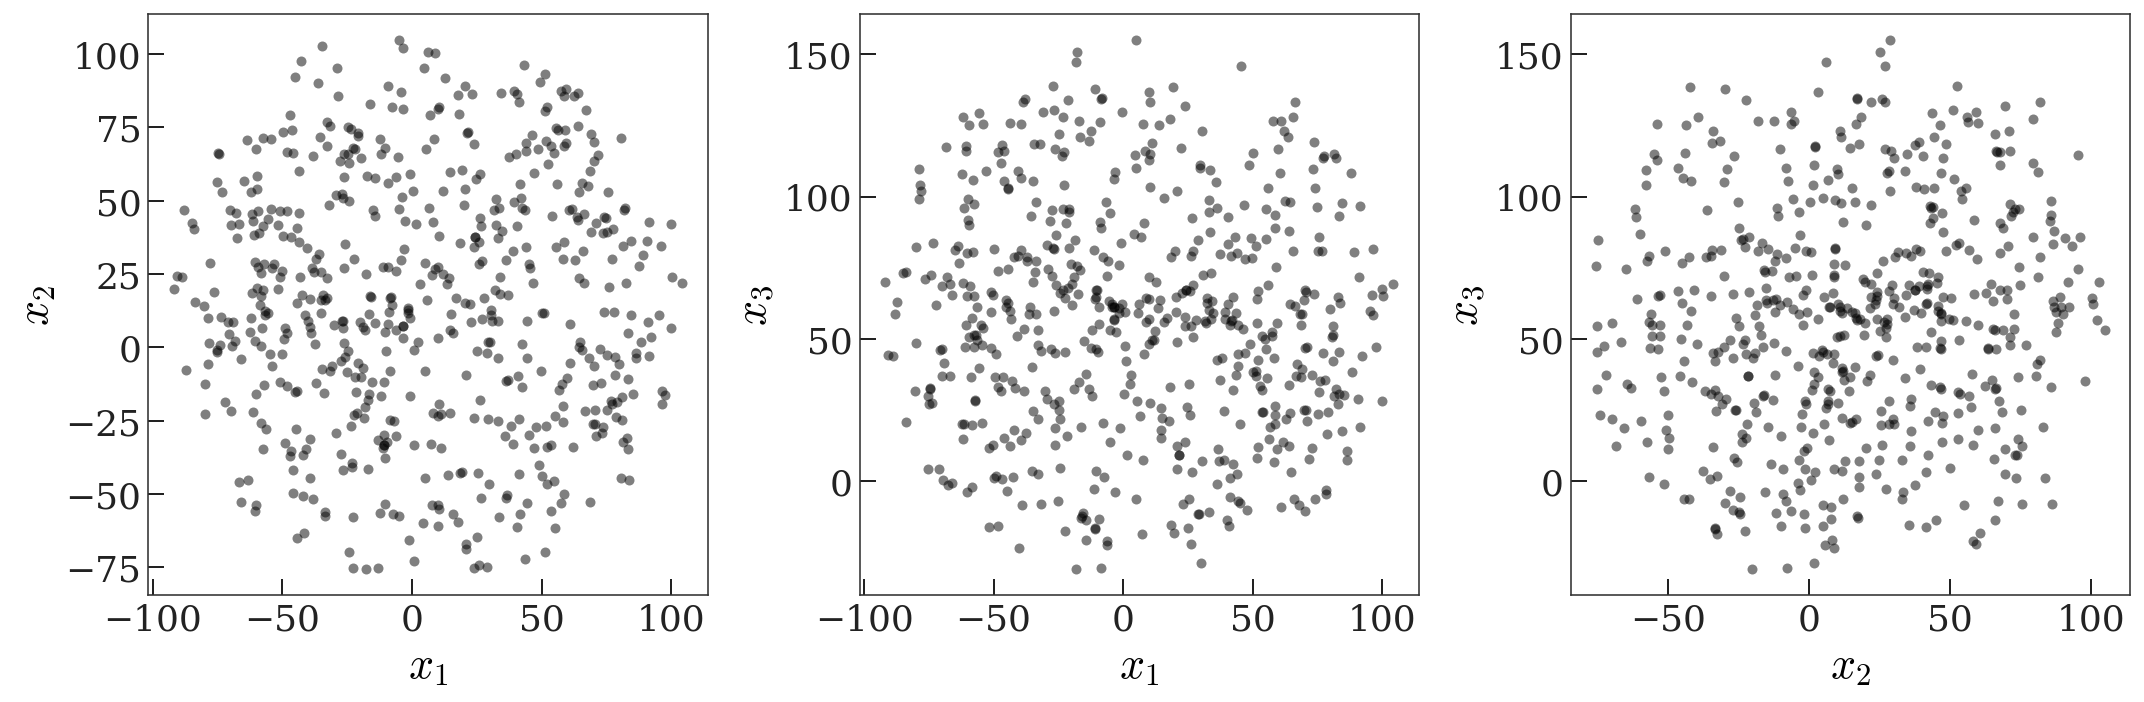

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]

    ax.plot(dx.xyz.to_value(u.pc)[i][cmd_mask],
            dx.xyz.to_value(u.pc)[j][cmd_mask],
            marker='o', ls='none', mew=0, ms=5, alpha=0.5)

    ax.set_xlabel(f'$x_{i+1}$')
    ax.set_ylabel(f'$x_{j+1}$')
fig.tight_layout()
fig.set_facecolor('w')

In [178]:
# vcirc from Eilers: https://ui.adsabs.harvard.edu/abs/2019ApJ...871..120E/abstract
vcirc = coord.CartesianDifferential([0, 229, 0.] * u.km/u.s)

In [179]:
dv = galcen.velocity - vcirc
alldv = allgalcen.velocity - vcirc

In [180]:
np.isfinite(dv.d_x).sum(), len(dv)

(165, 1262)

In [181]:
from scipy.ndimage import gaussian_filter

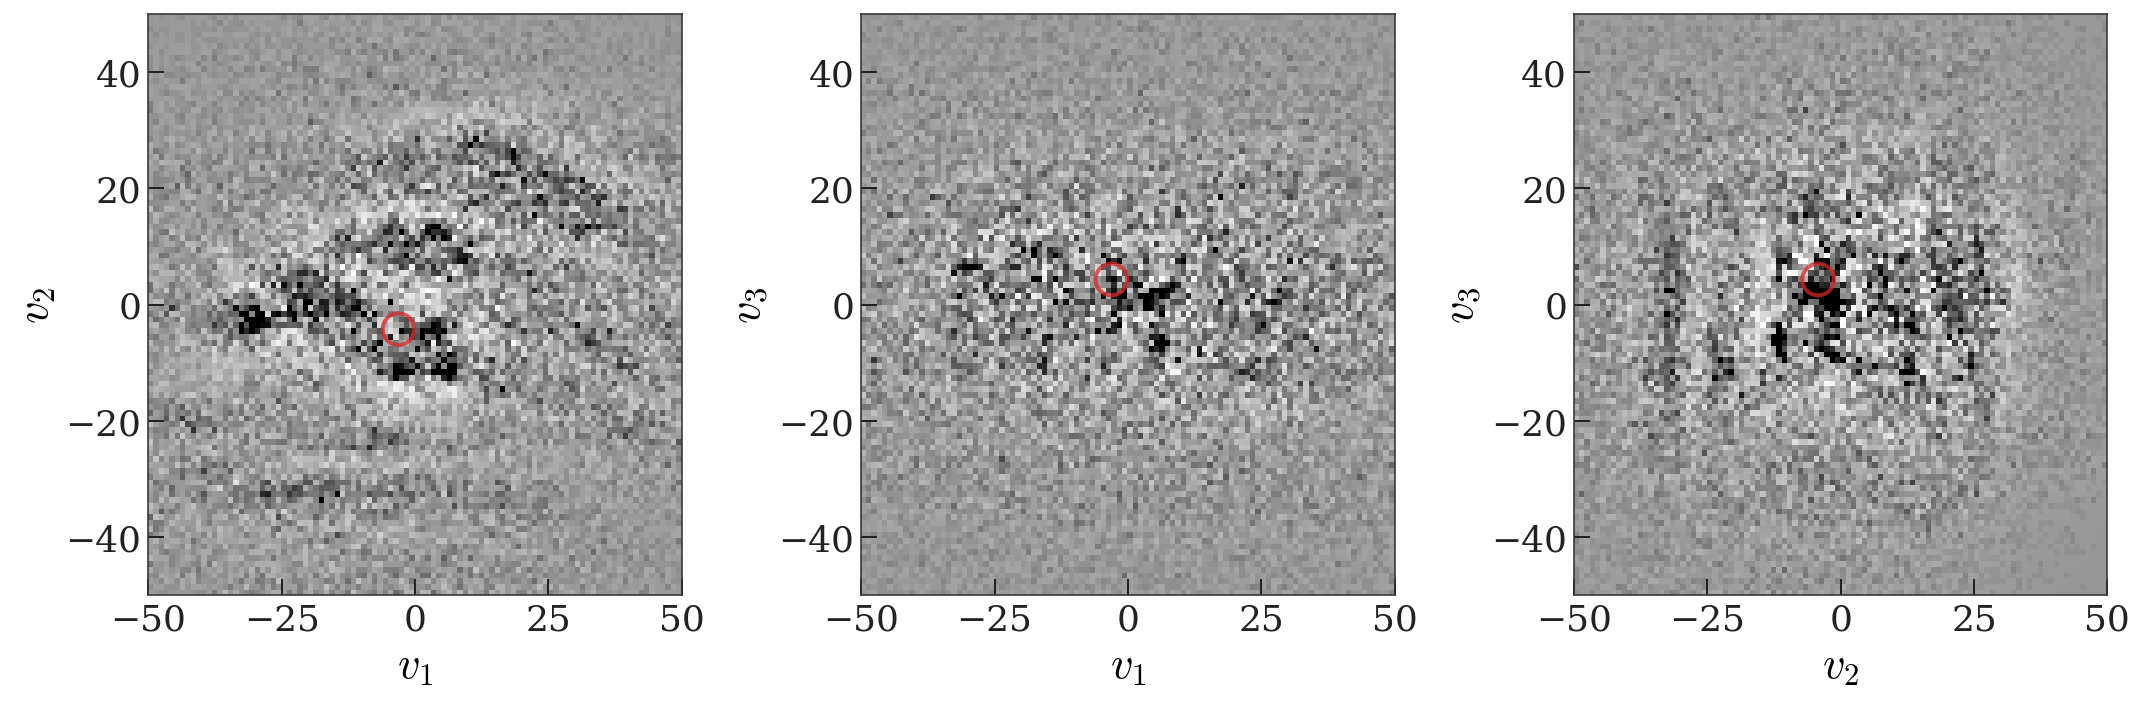

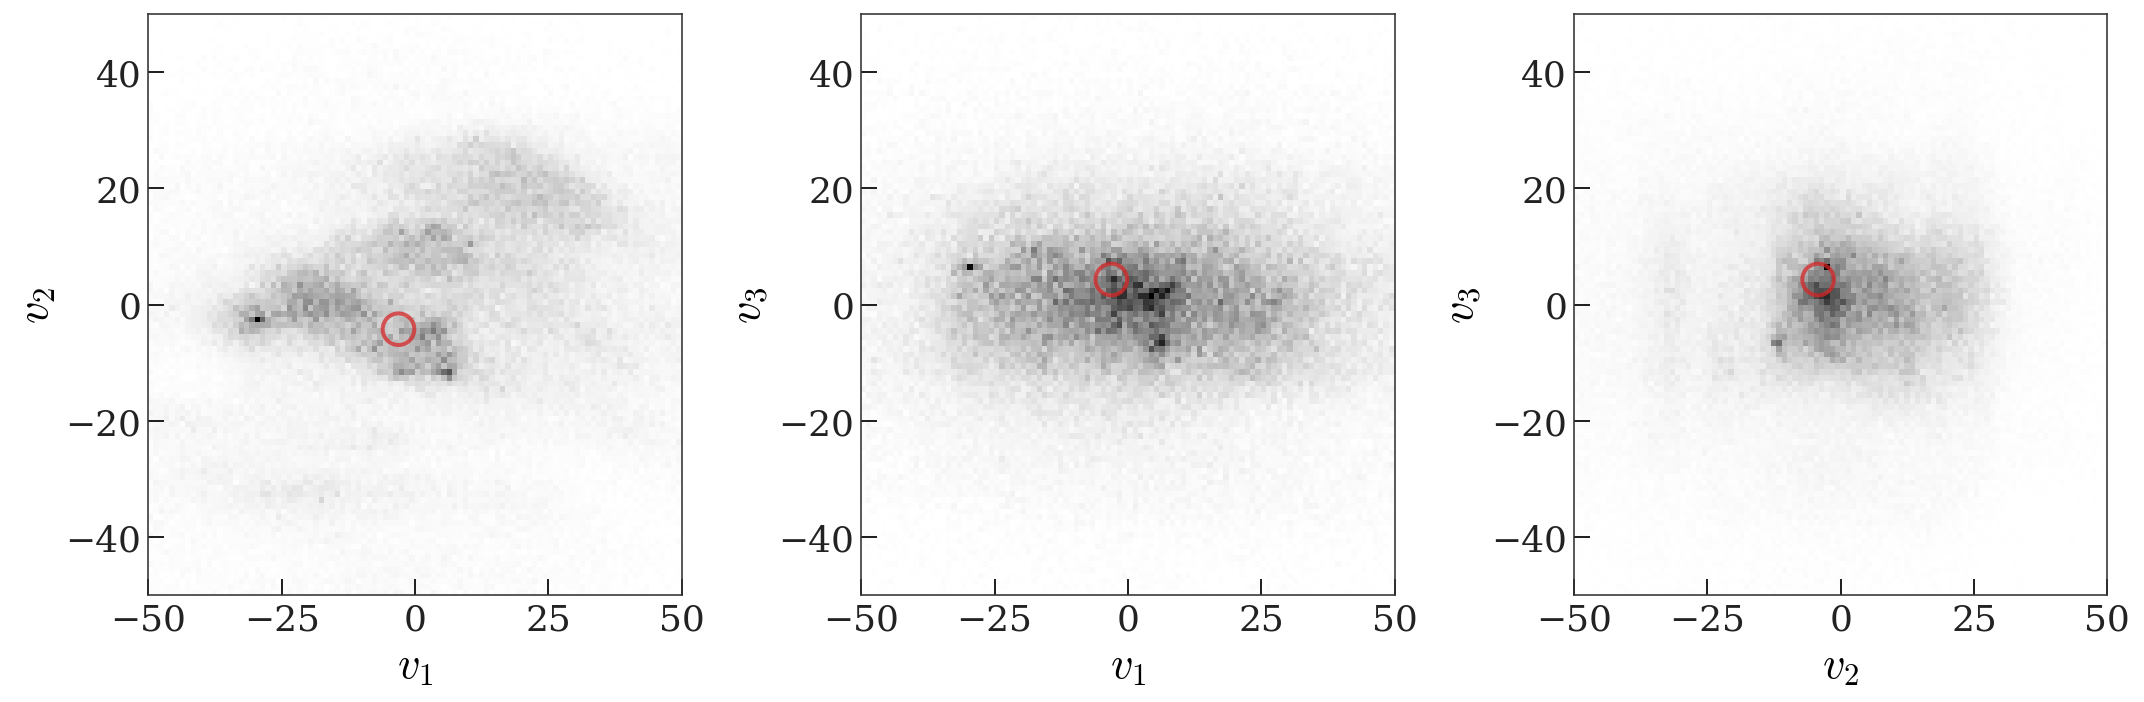

In [183]:
for cuddly in [True, False]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
        ax = axes[k]

        H, xe, ye = np.histogram2d(alldv.d_xyz.to_value(u.km/u.s)[i],
                                   alldv.d_xyz.to_value(u.km/u.s)[j],
                                   bins=np.arange(-50, 50+1e-3, 1))
        
#         ax.pcolormesh(xe, ye, H.T, 
#                       norm=mpl.colors.LogNorm(), cmap='Greys');
        if cuddly:
            H = H - gaussian_filter(H, sigma=3)
            ax.pcolormesh(xe, ye, H.T, cmap='Greys', vmin=-20, vmax=20)
        else:
            ax.pcolormesh(xe, ye, H.T, cmap='Greys')
        
        ax.scatter(np.nanmedian(dv.d_xyz.to_value(u.km/u.s)[i]),
                   np.nanmedian(dv.d_xyz.to_value(u.km/u.s)[j]),
                   marker='o', zorder=100, linewidth=2, facecolor='none', 
                   alpha=0.75, s=250, edgecolor='tab:red')
            
        ax.set_xlabel(f'$v_{i+1}$')
        ax.set_ylabel(f'$v_{j+1}$')
    fig.tight_layout()
    fig.set_facecolor('w')